<a href="https://colab.research.google.com/github/yeb2Binfang/sklearn_learning/blob/main/RandomForest/RandomForest_Fillna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

我们现实生活中的数据，总是会有一些缺失值，这时，random forest是一个好方法来填补这些缺失值。

我们一般的做法有时就删掉，有时就补0，有时就补均值等。

在sklearn中，我们可以使用sklearn.impute.SimpleInputer来轻松地将均值，中值，或者其他最常用的数值填补到数据中。

在这个案例中，我们将使用均值，0，和随机森林回归来填补缺失值，并验证下拟合状况，来找出对使用的数据集的最佳填补缺失值的办法

##导包

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


##导入数据，看看数据有什么

In [22]:
boston_data = load_boston().data
print(boston_data.shape)

X, y = boston_data, load_boston().target
print(X[:5])
print(y[:5])

(506, 13)
[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
  6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
  4.0300e+00]
 [3.2370e-02 0.0000e+00 2.1800e+00 0.0000e+00 4.5800e-01 6.9980e+00
  4.5800e+01 6.0622e+00 3.0000e+00 2.2200e+02 1.8700e+01 3.9463e+02
  2.9400e+00]
 [6.9050e-02 0.0000e+00 2.1800e+00 0.0000e+00 4.5800e-01 7.1470e+00
  5.4200e+01 6.0622e+00 3.0000e+00 2.2200e+02 1.8700e+01 3.9690e+02
  5.3300e+00]]
[24.  21.6 34.7 33.4 36.2]


In [23]:
n_samples = X.shape[0]
n_features = X.shape[1]


##为完整数据集放入缺失值

In [24]:
#首先，我们得先去确定下我们希望放入的缺失值的比例，在这里，我们假设是50%，原先我们有506*13 = 6578个数据，我们假设是50%，那么，就会有50%的数据进行替换补缺

rng = np.random.RandomState(0) #就是random state
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
print(n_missing_samples)

3289


In [25]:
#所有数据要随机遍布在数据集的各行各列中，而一个缺失的数据需要行列索引，然后在这个索引中填值
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的索引，那么我们就可以利用索引来为数据中的任意3289个位置赋空值
#然后，我们用0， 均值，随机森林来填写这些缺失值，然后查看回归的结果如何

#产生3289个[0~13)的数值
missing_features = rng.randint(0,n_features,n_missing_samples)
print(missing_features)
missing_samples = rng.randint(0,n_samples,n_missing_samples)

#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。但如果我们需要
#的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
#因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中
#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)


[12  5  0 ... 11  0  2]


In [26]:
#我们重新复制一份data，这样就不会破坏原来的数据
X_missing = X.copy()
y_missing = y.copy()

#missing_samples, missing_features 是我们上面生成的
#现在，我们把这些位置的值变为nan
X_missing[missing_samples, missing_features] = np.nan


我们把X_missing转换成dataframe，方便索引。其次，我们也看到，我们在特定位置生成了nan value

In [27]:
X_missing = pd.DataFrame(X_missing)
X_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


##用0和均值补缺失值

使用均值填补

In [28]:
#使用均值进行填补
imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)
X_missing_mean = pd.DataFrame(X_missing_mean)
X_missing_mean

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.627579,18.000000,11.163464,0.066007,0.538000,6.305921,65.2,4.090000,1.000000,296.000000,18.521192,352.741952,4.980000
1,0.027310,0.000000,11.163464,0.000000,0.469000,6.305921,78.9,4.967100,2.000000,405.935275,18.521192,396.900000,9.140000
2,0.027290,10.722951,7.070000,0.000000,0.564128,7.185000,61.1,3.856371,2.000000,242.000000,18.521192,352.741952,12.991767
3,3.627579,10.722951,11.163464,0.000000,0.458000,6.305921,45.8,3.856371,9.383871,222.000000,18.700000,352.741952,12.991767
4,3.627579,0.000000,2.180000,0.000000,0.564128,7.147000,67.4,3.856371,9.383871,405.935275,18.700000,352.741952,5.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,3.627579,10.722951,11.163464,0.000000,0.573000,6.305921,69.1,3.856371,1.000000,405.935275,21.000000,352.741952,9.670000
502,0.045270,0.000000,11.930000,0.000000,0.573000,6.120000,76.7,2.287500,1.000000,273.000000,18.521192,396.900000,9.080000
503,3.627579,10.722951,11.930000,0.066007,0.573000,6.976000,91.0,3.856371,9.383871,405.935275,21.000000,352.741952,5.640000
504,0.109590,0.000000,11.930000,0.066007,0.573000,6.305921,89.3,3.856371,1.000000,405.935275,21.000000,393.450000,6.480000


In [29]:
#check下是有还有控制
#false = 0, true = 1, 所以就每一个column的值都返回0
X_missing_mean.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

使用0进行填补

In [30]:
imp_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)
X_missing_0 = pd.DataFrame(X_missing_0)
X_missing_0

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00000,18.0,0.00,0.0,0.538,0.000,65.2,4.0900,1.0,296.0,0.0,0.00,4.98
1,0.02731,0.0,0.00,0.0,0.469,0.000,78.9,4.9671,2.0,0.0,0.0,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.000,7.185,61.1,0.0000,2.0,242.0,0.0,0.00,0.00
3,0.00000,0.0,0.00,0.0,0.458,0.000,45.8,0.0000,0.0,222.0,18.7,0.00,0.00
4,0.00000,0.0,2.18,0.0,0.000,7.147,0.0,0.0000,0.0,0.0,18.7,0.00,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.00000,0.0,0.00,0.0,0.573,0.000,69.1,0.0000,1.0,0.0,21.0,0.00,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,0.0,396.90,9.08
503,0.00000,0.0,11.93,0.0,0.573,6.976,91.0,0.0000,0.0,0.0,21.0,0.00,5.64
504,0.10959,0.0,11.93,0.0,0.573,0.000,89.3,0.0000,1.0,0.0,21.0,393.45,6.48


In [31]:
#check下是有还有控制
#false = 0, true = 1, 所以就每一个column的值都返回0
X_missing_0.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

##使用随机森林来填补缺失值

使用随机森林回归来填补缺失值。

任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能实现这个过程，是因为回归算法认为，特征矩阵和标签之间存在着某种关系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数量”来预测“房价”的问题中，我们既可以用“地区，环境，学校数量”来预测“房价”，也可以反过来，用“环境”，“附近学校数量”，和“房价”来预测“地区”。而回归填补缺失值，正是利用了这个思想。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当做标签，其他的n-1个特征和原本的标签组成新的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的y_train，而缺失的部分，就是我们的y_test。

特征T不缺失的值对应的其他n-1个特征 + 本来标签：X_train
特征T不缺失的值：y_train

特征T不缺失的值对应的其他n-1个特征 + 本来标签：X_test
特征T缺失的值：y_test

这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？

那么就遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。

填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征就会少一个，所以每次循环后，需要用0来填补的特征就会越来越少当进行到最后一个特征时（这个特征时缺失值最多的），已经没有任何其他特征需要用0来进行填补了。


In [32]:
X_missing_Ranreg = X_missing.copy()
#我们要按缺失值的数量从小到大进行排列，但我们需要返回index
sortindex = np.argsort(X_missing_Ranreg.isnull().sum()).values
print(sortindex)


[ 6 12  8  7  9  0  2  1  5  4  3 10 11]


In [33]:
X_missing_Ranreg = pd.DataFrame(X_missing_Ranreg)
X_missing_Ranreg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [37]:
#对已经排序好的每一列进行补值

for i in sortindex:
  #构建新特征矩阵和新标签
  #我们最终是要在X_missing_Ranreg这里填补数据的，所以，X_missing_Ranreg不能乱改
  #每次都要update新的数据
  df = X_missing_Ranreg
  #进行切片，我们需要提取的那一列给提取出来
  fillc = df.iloc[:,i]

  #把target和其他特征给连接起来
  df = pd.concat([df.iloc[:,df.columns != i], pd.DataFrame(y)],axis=1)

  #在新特征矩阵中，对缺失值进行填补,我们在这里补0
  df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
  df_0 = df_0.fit_transform(df)

  #找出训练集和测试集
  #我们得知道有缺失值的index
  y_train = fillc[fillc.notnull()]
  y_test = fillc[fillc.isnull()]
  X_train = df_0[y_train.index,:]
  X_test = df_0[y_test.index,:]

  #用随机森林来填补缺失值
  rfc = RandomForestRegressor(n_estimators=100)
  rfc.fit(X_train, y_train)
  y_pred = rfc.predict(X_test)

  #将填补好的缺失值放回去
  #定位到具体某一列
  #这样进行下一轮时，我们就可以使用这个预测数据
  X_missing_Ranreg.loc[X_missing_Ranreg.iloc[:,i].isnull(),i] = y_pred




In [38]:
#这样就把所有的缺失值给补上了
print(X_missing_Ranreg.isnull().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64


##对填补好的数据进行评估

In [39]:
#进行建模，然后取得MSE结果
x_all = [X, X_missing_mean, X_missing_0, X_missing_Ranreg]
mse = []
std = []

for x in x_all:
  estimator = RandomForestRegressor(n_estimators=100, random_state=0)
  scores = cross_val_score(estimator, x, y,scoring="neg_mean_squared_error",cv=5).mean()
  mse.append(scores*(-1))
  

输出结果,我们看到使用随机森林来填补缺失值会降低MSE，证明还不错

In [41]:
[*zip(["X_full","X_missing_mean","X_missing_0","X_missing_Ranreg"],mse)]

[('X_full', 21.62860460743544),
 ('X_missing_mean', 40.84405476955929),
 ('X_missing_0', 49.50657028893417),
 ('X_missing_Ranreg', 18.830708107746055)]

##Visualize the result

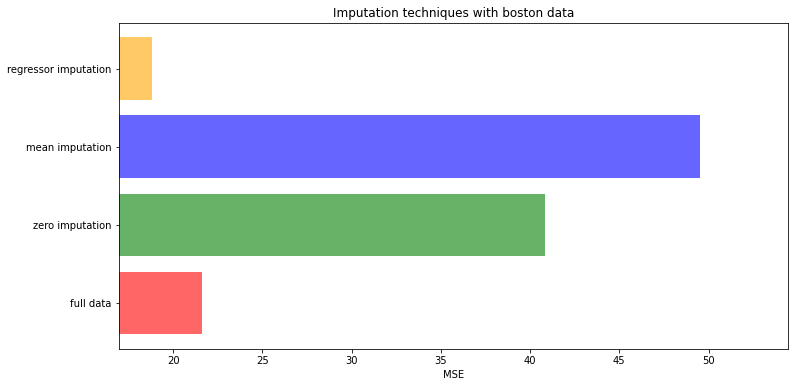

In [45]:
x_labels = ['full data','zero imputation','mean imputation','regressor imputation']
colors = ['r','g','b','orange']
plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
  ax.barh(i,mse[i],color = colors[i], alpha=0.6,align='center') #alpha表示粗度
ax.set_title("Imputation techniques with boston data")
ax.set_xlim(left = np.min(mse)*0.9,right = np.max(mse)*1.1) 
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()

从上图可以看出regressor 来填补缺失值效果不错，但是要注意过拟合的风险